# Import libraries

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys
from pathlib import Path
import re
import joblib
from pathlib import Path

# Load data

In [23]:
path_1K = "../../data/1000G/"
chroms = os.listdir(f"{path_1K}/chunks")
for chrom in chroms:
    path_chrom = f"{path_1K}/chunks/{chrom}"
    chunks = os.listdir(path_chrom)

    first = pd.read_pickle(f"{path_chrom}/{chunks[0]}")
    split_cols = first['IID'].str.split('_', n=1, expand=True)
    first['subpopulation'] = split_cols[0]
    first['population']    = split_cols[1]
    iid_idx = first.columns.get_loc('IID')
    for col in ['population', 'subpopulation'][::-1]:
        first.insert(iid_idx + 1, col, first.pop(col))
    non_snp_cols = ['FID', 'IID','population','subpopulation', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'] 
    
    for chunk in chunks:
        path_chunk = f"{path_chrom}/{chunk}"

In [27]:
path_1K = "../../data/1000G/"
chunks_root = os.path.join(path_1K, "chunks")

non_snp_cols = ['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE']
# We'll add the parsed population info, too:
derived_cols = ['population', 'subpopulation']
non_snp_cols_full = non_snp_cols + derived_cols

pheno_saved = False

# Traverse chromosomes in a stable order
for chrom in sorted(os.listdir(chunks_root)):
    path_chrom = os.path.join(chunks_root, chrom)
    if not os.path.isdir(path_chrom):
        continue

    # All chunks for this chromosome (sorted for determinism)
    chunks = sorted(os.listdir(path_chrom))
    if not chunks:
        continue

    # --- 1) Load the very first chunk ONCE (first chrom, first chunk) to build pheno ---
    if not pheno_saved:
        first_path = os.path.join(path_chrom, chunks[0])
        first = pd.read_pickle(first_path)

        # Parse IID into (subpopulation, population) and insert next to IID
        split_cols = first['IID'].astype(str).str.split('_', n=1, expand=True)
        first['subpopulation'] = split_cols[0]
        first['population']    = split_cols[1] if split_cols.shape[1] > 1 else pd.NA

        # Build pheno with just the non-SNP columns (keep order, drop dups if any)
        # Some datasets name columns differently; select by intersection to be safe:
        keep_cols = [c for c in non_snp_cols_full if c in first.columns]
        pheno = first[keep_cols].drop_duplicates().reset_index(drop=True)
        # pheno.to_pickle(os.path.join(out_root, "pheno.pkl"))
        pheno_saved = True


    # --- 2) For every chunk (including the first), drop non-SNP columns and save SNP-only ---
    for chunk in chunks:
        path_chunk = os.path.join(path_chrom, chunk)
        try:
            df = pd.read_pickle(path_chunk)
        except Exception as e:
            print(f"Skipping {path_chunk} (read error: {e})")
            continue

        # If IID parsing wasn't done in this chunk, that's fine — we drop these anyway
        # Just drop any of the non-SNP columns that exist in this df:
        drop_cols = [c for c in non_snp_cols_full if c in df.columns]
        df_snp = df.drop(columns=drop_cols, errors='ignore')


In [28]:
pheno

,FID,IID,PAT,MAT,SEX,PHENOTYPE,population,subpopulation
0,HG00096,EUR_GBR,0,0,1,-9,GBR,EUR
1,HG00097,EUR_GBR,0,0,2,-9,GBR,EUR
2,HG00099,EUR_GBR,0,0,2,-9,GBR,EUR
3,HG00100,EUR_GBR,0,0,2,-9,GBR,EUR
4,HG00101,EUR_GBR,0,0,1,-9,GBR,EUR
...,...,...,...,...,...,...,...,...
2499,NA21137,SAS_GIH,0,0,2,-9,GIH,SAS
2500,NA21141,SAS_GIH,0,0,2,-9,GIH,SAS
2501,NA21142,SAS_GIH,0,0,2,-9,GIH,SAS
2502,NA21143,SAS_GIH,0,0,2,-9,GIH,SAS


In [29]:
df_snp

,rs2953108_C,rs200528186_G,rs372779614_T,rs377395690_C,rs2212121_C,rs528935526_G,rs201979747_G,rs200386828_T,rs201456653_G,rs200483765_T,...,rs2157711_G,rs12628091_T,rs73174424_C,rs79183605_G,rs12158487_C,rs6010067_G,rs4040034_A,rs9616827_A,rs2519461_G,rs375798137_G
0,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
1,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0,0,1
3,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2500,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2501,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2502,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1


In [37]:
# 1) Standardize once
scaler = StandardScaler(with_mean=True, with_std=True)
float_dtype=np.float32
randomized=True
seed=42
X_std = scaler.fit_transform(df_snp.astype(float_dtype, copy=False))

# 2) Fit PCA once up to the largest k
pca = PCA(
    n_components=2,
    svd_solver="randomized" if randomized else "full",
    random_state=seed
)
scores = pca.fit_transform(X_std)        # shape: (n_samples, n_max)


In [39]:

df = pd.DataFrame(scores[:, :2], columns=[f"PC{i}" for i in range(1, 2+1)])

In [44]:
df['pop'] = pheno['subpopulation']

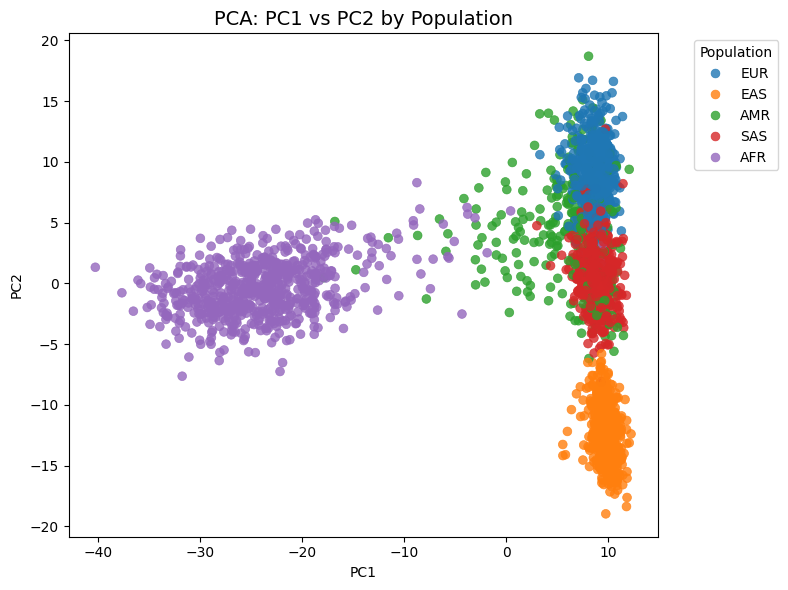

In [45]:
# assuming your dataframe is called df
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="PC1",
    y="PC2",
    hue="pop",
    s=40,           # point size
    alpha=0.8,      # transparency
    edgecolor=None  # cleaner look
)

plt.title("PCA: PC1 vs PC2 by Population", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Population", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()